# Cat vs Non Cat Exercise

Experimente resolver o problema com um perceptron apenas (regressão logistica), uma rede de camada rasa e uma rede convolucional. Além da demonstração das redes funcionando, um Relatório completo deve ser entregue, contendo informações de Quantos e Quais experimentos foram feitos até chegar no resultado final; Como foi o treinamento; Qual a taxa de acertos da rede; A matriz de confusão, etc...

## Notebook structure

- Import libraries
- Data Preparation
- Data preprocessing


## Importing libraries


In [ ]:
import os

import pandas as pd
import numpy as np
import math
import itertools

import h5py

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical

from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam


import matplotlib.pyplot as plt
import seaborn as sns

import visualkeras
from PIL import ImageFont

import logging
    
for name in logging.Logger.manager.loggerDict.keys():
    logging.getLogger(name).setLevel(logging.CRITICAL)


## Data preparation


In [ ]:
IMAGE_SIZE = 256
IMAGE_DIRECTORY = './Data/'


In [ ]:
filename = 'train_catvnoncat.h5'
f = h5py.File(IMAGE_DIRECTORY+filename, 'r')


In [ ]:
list(f.keys())


In [ ]:
data_train = list(f['train_set_x'])
data_label = list(f['train_set_y'])


In [ ]:
X_tr = np.array(data_train)
y_tr = np.array(data_label)

In [ ]:
filename = 'test_catvnoncat.h5'
f = h5py.File(IMAGE_DIRECTORY+filename, 'r')


In [ ]:
list(f.keys())


In [ ]:
data_test = list(f['test_set_x'])
data_label_test = list(f['test_set_y'])


In [ ]:
X_test = np.array(data_test)
y_test = np.array(data_label_test)


In [ ]:
def rgb2grayscale(imgs_array):
    #
    # Reshaping to flatten
    #
    rgb_weights = [0.2989, 0.5870, 0.1140]

    X_tr_new = []

    for i in range(imgs_array.shape[0]):
        new_img = np.dot(imgs_array[i], rgb_weights)
        X_tr_new.append(new_img)

    X_tr_new = np.array(X_tr_new)
    return X_tr_new

## Data visualization


In [ ]:
print(data_train[1].shape)
n = 20
plt.figure(figsize=(15, 15))
for i in range(n):
    ax = plt.subplot(4, 5, i + 1)
    plt.imshow(data_train[i+10])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()


## Checking class balacing


In [ ]:
sns.set_style('darkgrid')
sns.countplot(y_tr, palette='twilight')


In [ ]:
#
# Calculating class weights
#

from sklearn.utils.class_weight import compute_class_weight

list_y_tr = list(y_tr)
class_weights = compute_class_weight(
    class_weight='balanced', classes=np.unique(list_y_tr), y=list_y_tr)
print("Labels:", np.unique(list_y_tr))
print("Class weights:", class_weights)
d_class_weights = dict(enumerate(class_weights))


## Dataset splitting


In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(
    X_tr, y_tr, test_size=0.1, stratify=y_tr, random_state=123)
print('Shape of train set feature', X_train.shape)
print('Shape of validation set feature', X_val.shape)
print('Shape of train set label', Y_train.shape)
print('Shape of validation set label', Y_val.shape)

num_classes = 2
input_shape = (64, 64, 3)

Y_train = to_categorical(Y_train, num_classes)
Y_val = to_categorical(Y_val, num_classes)
Y_test = to_categorical(y_test, num_classes)


## Experiments with Convolutional Neural Networks


In [ ]:

tf.keras.backend.clear_session()

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)


In [ ]:
lr = 0.001

# Compile the model.
model.compile(
    optimizer=Adam(learning_rate=lr),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)
model.summary()


### Visualizing the network architecture

Convolutional layers in yellow
Max Pooling in red
Dense in blue-green


In [ ]:
# Visualizing the network
visualkeras.layered_view(model, legend=True)


In [ ]:
model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=20, batch_size=16,
          class_weight=d_class_weights)


In [ ]:
acc = model.history.history['accuracy']
val_acc = model.history.history['val_accuracy']
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()


In [ ]:
TrainPredictions = model.predict(X_train)
TrainPredictions = np.argmax(TrainPredictions, axis=1)


In [ ]:
train_labels = np.argmax(Y_train, axis=1)
conf = confusion_matrix(train_labels, TrainPredictions)

classes = [0, 1]
# plot confusion matrix
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.Greens)
plt.title("Train Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf.max() / 2.
for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
    plt.text(j, i, format(conf[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')


In [ ]:
from sklearn.metrics import accuracy_score
print('\nAccuracy: {:.4f}\n'.format(
    accuracy_score(train_labels, TrainPredictions)))


In [ ]:
TestPredictions = model.predict(X_test)
TestPredictions = np.argmax(TestPredictions, axis=1)


In [ ]:
test_labels = np.argmax(Y_test, axis=1)
conf = confusion_matrix(test_labels, TestPredictions)

classes = [0, 1]
# plot confusion matrix
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.Greens)
plt.title("Test Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf.max() / 2.
for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
    plt.text(j, i, format(conf[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')


In [ ]:
print('\nAccuracy: {:.4f}\n'.format(
    accuracy_score(test_labels, TestPredictions)))


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(test_labels,TestPredictions))

open("report_cnn.txt", "w+").write(str(classification_report(test_labels,TestPredictions)))

In [ ]:
import pandas as pd
df = pd.DataFrame(confusion_matrix(test_labels, TestPredictions))
df.to_excel("cm_cnn.xlsx")

In [ ]:
print(X_test[1].shape)
x = np.expand_dims(X_test[1], axis=0)
print(x.shape)
Predictions = model.predict(x)


In [ ]:
import random

n = [random.randint(0, len(data_test)) for i in range(5)]

for i in n:
    #ax = plt.subplot(4, 5, i + 1)
    ax = plt.subplot()
    plt.imshow(data_test[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.show()

    Predictions = model.predict(np.expand_dims(X_test[i], axis=0))
    Predictions = np.argmax(Predictions, axis=1)
    if Predictions == 0:
        print('NAO E UM GATO')
    else:
        print('E UM GATO')


## Experiments with Logistic Regression


In [ ]:
# Data loading
IMAGE_SIZE = 256
IMAGE_DIRECTORY = './Data/'

filename = 'train_catvnoncat.h5'
f = h5py.File(IMAGE_DIRECTORY+filename, 'r')

list(f.keys())


In [ ]:
data_train = list(f['train_set_x'])
data_label = list(f['train_set_y'])


In [ ]:
# Data preprocessing
X_tr = np.array(data_train)
y_tr = np.array(data_label)

X_tr_gray = rgb2grayscale(X_tr)


#
# Reshaping to flatten
#
X_tr = X_tr_gray.reshape((X_tr_gray.shape[0], -1))
y_tr = y_tr.reshape((y_tr.shape[0], -1))


In [ ]:
y_tr.shape


In [ ]:
X_tr.shape


In [ ]:
filename = 'test_catvnoncat.h5'
f = h5py.File(IMAGE_DIRECTORY+filename, 'r')

data_test = list(f['test_set_x'])
data_label_test = list(f['test_set_y'])

X_test = np.array(data_test)
y_test = np.array(data_label_test)


X_test_gray = rgb2grayscale(X_test)


#
# Reshaping to flatten
#
X_test = X_test_gray.reshape((X_test_gray.shape[0], -1))
y_test = y_test.reshape((y_test.shape[0]))


In [ ]:
X_test.shape

In [ ]:
from sklearn.preprocessing import MinMaxScaler
# Data scaling

scaler = MinMaxScaler()

scaler.fit(X_tr)

X_tr_scaled = scaler.transform(X_tr)
X_test_scaled= scaler.transform(X_test)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

class LogisticRegressionIAC():

    def __init__(self, params, input_shape) -> None:
        self.params = params
        self.input_shape = input_shape

    def search_best_hyperparams(self, X_train, y_train, class_weight):

        model = LogisticRegression(
            penalty="l2",
            max_iter=1000,
            n_jobs=2
        )
        print(model.get_params().keys())

        clf = GridSearchCV(model, params, verbose=0, n_jobs=11)
        clf.fit(X_train, y_train)
        
        print("Best params: ", clf.best_params_)
        print("Best estimator:", clf.best_estimator_)
        with open("best_lr.txt", "w+") as fp:
            fp.write("Best params: " +str( clf.best_params_))

        return  clf.best_estimator_


    def clear_tf(self):
        tf.keras.backend.clear_session()


In [ ]:
# Model training and search for the best hyperparam

params = {
    "max_iter": [32, 64,128,256, 512, 1024],
    "penalty": ["l2" ,"none"],
    "C": [0, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5,],
    "solver":["lbfgs", "liblinear", "sag", "saga"],
    "l1_ratio":[0, 0.25, 0.5, 0.75, 1]
}

model = LogisticRegressionIAC(
    input_shape=X_train.shape,
    params=params
)

best_model = model.search_best_hyperparams(X_train=X_tr_scaled, y_train=y_tr, class_weight=d_class_weights)


In [ ]:
#
#
# Make predictions using the best model

y_pred = best_model.predict(X_test_scaled)



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test,y_pred))
open("report_lr.txt", "w+").write(str(classification_report(y_test,y_pred)))

In [ ]:
cm = confusion_matrix(y_test, y_pred)
import pandas as pd
df = pd.DataFrame(cm)
df.to_excel("cm_lr.xlsx")

### Experiments with Simple NN



In [ ]:
# Data loading
IMAGE_SIZE = 256
IMAGE_DIRECTORY = './Data/'

filename = 'train_catvnoncat.h5'
f = h5py.File(IMAGE_DIRECTORY+filename, 'r')

list(f.keys())


In [ ]:
data_train = list(f['train_set_x'])
data_label = list(f['train_set_y'])


In [ ]:
# Data preprocessing
X_tr = np.array(data_train)
y_tr = np.array(data_label)

#
# Reshaping to flatten
#
rgb_weights = [0.2989, 0.5870, 0.1140]
grayscale_image = np.dot(X_tr, rgb_weights)

X_tr_new = []

for i in range(X_tr.shape[0]):
    new_img = np.dot(X_tr[i], rgb_weights)
    X_tr_new.append(new_img)

X_tr_new = np.array(X_tr_new)
X_tr_new = X_tr_new.reshape((X_tr_new.shape[0], -1))
y_tr = y_tr.reshape((y_tr.shape[0]))


In [ ]:
filename = 'test_catvnoncat.h5'
f = h5py.File(IMAGE_DIRECTORY+filename, 'r')

data_test = list(f['test_set_x'])
data_label_test = list(f['test_set_y'])

X_test = np.array(data_test)
y_test = np.array(data_label_test)


#
# Reshaping to flatten
#
X_test_new = []

for i in range(X_test.shape[0]):
    new_img = np.dot(X_test[i], rgb_weights)
    X_test_new.append(new_img)

X_test_new = np.array(X_test_new)
X_test_new = X_test_new.reshape((X_test_new.shape[0], -1))
y_test = y_test.reshape((y_test.shape[0]))


In [ ]:
print("Train shape:", X_tr_new.shape)
print("Test shape:", X_test_new.shape)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
# Data scaling

scaler = MinMaxScaler()

scaler.fit(X_tr_new)

X_tr_scaled = scaler.transform(X_tr_new)
X_test_scaled= scaler.transform(X_test_new)

In [ ]:
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Sequential
from keras.optimizers import SGD
from keras.optimizers import Adam, RMSprop, Adadelta, Adagrad, Adamax,Nadam


def create_model(
        lr=1e-3, 
        hidden_layer_size=256,
        opt="adam",
        dropout=None,
        hidden_activation="relu",
        input_shape=X_train.shape[1]
    ):
    tf.keras.backend.clear_session()

  

    # Building model
    layers = []
    dense=Dense(hidden_layer_size, activation = hidden_activation, input_shape=(input_shape,))

    layers.append(dense)
    if dropout:
        layers.append(Dropout(dropout))

    # Output
    layers.append(Dense(1, activation="sigmoid"))
    model = Sequential(
       layers
    )

    metrics = [
        keras.metrics.FalseNegatives(name="fn"),
        keras.metrics.FalsePositives(name="fp"),
        keras.metrics.TrueNegatives(name="tn"),
        keras.metrics.TruePositives(name="tp"),
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
        keras.metrics.Accuracy(name="accuracy")
    ]

    optimizers = {
        "adam":Adam(lr),
        "sgd":SGD(lr),
        "rmsprop":RMSprop(lr),
        "adadelta":Adadelta(lr),
        "adagrad":Adagrad(lr),
        "adamax":Adamax(lr),
        "nadam":Nadam(lr)
    }
    model.compile(
        optimizer=optimizers[opt],  loss="binary_crossentropy", metrics=metrics
    )

    return model


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

class NN_IAC():

    def __init__(self, params, input_shape) -> None:
        self.params = params
        self.input_shape = input_shape

    def search_best_hyperparams(self, X_train, y_train, class_weight):

        model = KerasClassifier(
            build_fn=create_model, 
            input_shape=X_train.shape[1], 
            epochs=200, verbose=0, 
            hidden_layer_size=256
        )
        

        clf = GridSearchCV(model, params, verbose=2, n_jobs=1)
        clf.fit(X_train, y_train)
        
        print("Best params: ", clf.best_params_)
        print("Best estimator:", clf.best_estimator_)
        with open("best_mlp.txt", "w+") as fp:
            fp.write("Best params: " +str( clf.best_params_))

        return  clf.best_estimator_


    def clear_tf(self):
        tf.keras.backend.clear_session()


In [ ]:
# Model training and search for the best hyperparam

params = {
    "epochs": [16, 32, 64], # More than 64 epochs may generate
    "dropout":[None, 0.5],
    "lr": [1e-3, 1e-4],
    "batch_size": [32, 64],
    "hidden_layer_size": [256,512,1024],
    "opt":["adam", "sgd"],
    "hidden_activation":["tanh", "sigmoid", "softmax", "selu"],    
}

model = NN_IAC(
    input_shape=X_tr_new.shape,
    params=params
)

best_model = model.search_best_hyperparams(X_train=X_tr_new, y_train=y_tr, class_weight=d_class_weights)


In [ ]:
#
#
# Make predictions using the best model

y_pred = best_model.predict(X_test_new)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test,y_pred))

open("report_mlp.txt", "w+").write(str(classification_report(y_test,y_pred)))

In [ ]:
confusion_matrix(y_test, y_pred)

In [ ]:
import pandas as pd
df = pd.DataFrame(confusion_matrix(y_test, y_pred))
df.to_excel("cm_mlp.xlsx")

/home/trdp/anaconda3/envs/ml_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  


Text(0.5, 16.0, 'Predicted label')

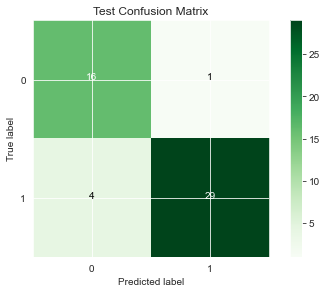

In [123]:
test_labels = np.argmax(Y_test, axis=1)
conf = confusion_matrix(test_labels, TestPredictions)

classes = [0, 1]
# plot confusion matrix
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.Greens)
plt.title("Test Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf.max() / 2.
for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
    plt.text(j, i, format(conf[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')


In [124]:
print('\nAccuracy: {:.4f}\n'.format(
    accuracy_score(test_labels, TestPredictions)))



Accuracy: 0.9000



In [135]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(test_labels,TestPredictions))

open("report_cnn.txt", "w+").write(str(classification_report(test_labels,TestPredictions)))

              precision    recall  f1-score   support

           0       0.80      0.94      0.86        17
           1       0.97      0.88      0.92        33

    accuracy                           0.90        50
   macro avg       0.88      0.91      0.89        50
weighted avg       0.91      0.90      0.90        50



326

In [138]:
import pandas as pd
df = pd.DataFrame(confusion_matrix(test_labels, TestPredictions))
df.to_excel("cm_cnn.xlsx")

In [125]:
print(X_test[1].shape)
x = np.expand_dims(X_test[1], axis=0)
print(x.shape)
Predictions = model.predict(x)


(64, 64, 3)
(1, 64, 64, 3)


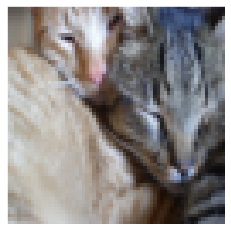

E UM GATO


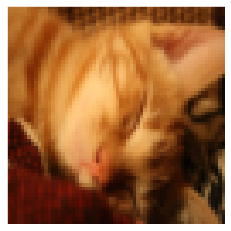

E UM GATO


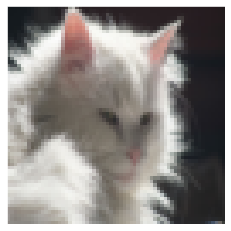

E UM GATO


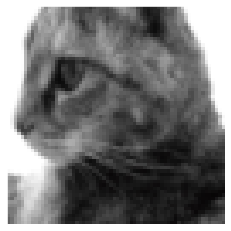

E UM GATO


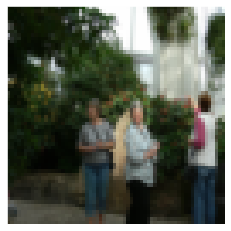

NAO E UM GATO


In [126]:
import random

n = [random.randint(0, len(data_test)) for i in range(5)]

for i in n:
    #ax = plt.subplot(4, 5, i + 1)
    ax = plt.subplot()
    plt.imshow(data_test[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.show()

    Predictions = model.predict(np.expand_dims(X_test[i], axis=0))
    Predictions = np.argmax(Predictions, axis=1)
    if Predictions == 0:
        print('NAO E UM GATO')
    else:
        print('E UM GATO')


## Experiments with Logistic Regression


In [67]:
# Data loading
IMAGE_SIZE = 256
IMAGE_DIRECTORY = './Data/'

filename = 'train_catvnoncat.h5'
f = h5py.File(IMAGE_DIRECTORY+filename, 'r')

list(f.keys())


['list_classes', 'train_set_x', 'train_set_y']

In [68]:
data_train = list(f['train_set_x'])
data_label = list(f['train_set_y'])


In [69]:
# Data preprocessing
X_tr = np.array(data_train)
y_tr = np.array(data_label)

X_tr_gray = rgb2grayscale(X_tr)


#
# Reshaping to flatten
#
X_tr = X_tr_gray.reshape((X_tr_gray.shape[0], -1))
y_tr = y_tr.reshape((y_tr.shape[0], -1))


In [70]:
y_tr.shape


(209, 1)

In [71]:
X_tr.shape


(209, 4096)

In [72]:
filename = 'test_catvnoncat.h5'
f = h5py.File(IMAGE_DIRECTORY+filename, 'r')

data_test = list(f['test_set_x'])
data_label_test = list(f['test_set_y'])

X_test = np.array(data_test)
y_test = np.array(data_label_test)


X_test_gray = rgb2grayscale(X_test)


#
# Reshaping to flatten
#
X_test = X_test_gray.reshape((X_test_gray.shape[0], -1))
y_test = y_test.reshape((y_test.shape[0]))


In [73]:
X_test.shape

(50, 4096)

In [74]:
from sklearn.preprocessing import MinMaxScaler
# Data scaling

scaler = MinMaxScaler()

scaler.fit(X_tr)

X_tr_scaled = scaler.transform(X_tr)
X_test_scaled= scaler.transform(X_test)

In [75]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

class LogisticRegressionIAC():

    def __init__(self, params, input_shape) -> None:
        self.params = params
        self.input_shape = input_shape

    def search_best_hyperparams(self, X_train, y_train, class_weight):

        model = LogisticRegression(
            penalty="l2",
            max_iter=1000,
            n_jobs=2
        )
        print(model.get_params().keys())

        clf = GridSearchCV(model, params, verbose=0, n_jobs=11)
        clf.fit(X_train, y_train)
        
        print("Best params: ", clf.best_params_)
        print("Best estimator:", clf.best_estimator_)
        with open("best_lr.txt", "w+") as fp:
            fp.write("Best params: " +str( clf.best_params_))

        return  clf.best_estimator_


    def clear_tf(self):
        tf.keras.backend.clear_session()


In [76]:
# Model training and search for the best hyperparam

params = {
    "max_iter": [32, 64,128,256, 512, 1024],
    "penalty": ["l2" ,"none"],
    "C": [0, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5,],
    "solver":["lbfgs", "liblinear", "sag", "saga"],
    "l1_ratio":[0, 0.25, 0.5, 0.75, 1]
}

model = LogisticRegressionIAC(
    input_shape=X_train.shape,
    params=params
)

best_model = model.search_best_hyperparams(X_train=X_tr_scaled, y_train=y_tr, class_weight=d_class_weights)


dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])


/home/trdp/anaconda3/envs/ml_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)
/home/trdp/anaconda3/envs/ml_env/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/trdp/anaconda3/envs/ml_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)
/home/trdp/anaconda3/envs/ml_env/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

Best params:  {'C': 1e-10, 'l1_ratio': 0, 'max_iter': 32, 'penalty': 'l2', 'solver': 'lbfgs'}
Best estimator: LogisticRegression(C=1e-10, l1_ratio=0, max_iter=32, n_jobs=2)


In [77]:
#
#
# Make predictions using the best model

y_pred = best_model.predict(X_test_scaled)



In [78]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test,y_pred))
open("report_lr.txt", "w+").write(str(classification_report(y_test,y_pred)))

              precision    recall  f1-score   support

           0       0.34      1.00      0.51        17
           1       0.00      0.00      0.00        33

    accuracy                           0.34        50
   macro avg       0.17      0.50      0.25        50
weighted avg       0.12      0.34      0.17        50



/home/trdp/anaconda3/envs/ml_env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/trdp/anaconda3/envs/ml_env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/trdp/anaconda3/envs/ml_env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

326

In [79]:
cm = confusion_matrix(y_test, y_pred)
import pandas as pd
df = pd.DataFrame(cm)
df.to_excel("cm_lr.xlsx")

### Experiments with Simple NN



In [80]:
# Data loading
IMAGE_SIZE = 256
IMAGE_DIRECTORY = './Data/'

filename = 'train_catvnoncat.h5'
f = h5py.File(IMAGE_DIRECTORY+filename, 'r')

list(f.keys())


['list_classes', 'train_set_x', 'train_set_y']

In [81]:
data_train = list(f['train_set_x'])
data_label = list(f['train_set_y'])


In [82]:
# Data preprocessing
X_tr = np.array(data_train)
y_tr = np.array(data_label)

#
# Reshaping to flatten
#
rgb_weights = [0.2989, 0.5870, 0.1140]
grayscale_image = np.dot(X_tr, rgb_weights)

X_tr_new = []

for i in range(X_tr.shape[0]):
    new_img = np.dot(X_tr[i], rgb_weights)
    X_tr_new.append(new_img)

X_tr_new = np.array(X_tr_new)
X_tr_new = X_tr_new.reshape((X_tr_new.shape[0], -1))
y_tr = y_tr.reshape((y_tr.shape[0]))


In [83]:
filename = 'test_catvnoncat.h5'
f = h5py.File(IMAGE_DIRECTORY+filename, 'r')

data_test = list(f['test_set_x'])
data_label_test = list(f['test_set_y'])

X_test = np.array(data_test)
y_test = np.array(data_label_test)


#
# Reshaping to flatten
#
X_test_new = []

for i in range(X_test.shape[0]):
    new_img = np.dot(X_test[i], rgb_weights)
    X_test_new.append(new_img)

X_test_new = np.array(X_test_new)
X_test_new = X_test_new.reshape((X_test_new.shape[0], -1))
y_test = y_test.reshape((y_test.shape[0]))


In [84]:
print("Train shape:", X_tr_new.shape)
print("Test shape:", X_test_new.shape)

Train shape: (209, 4096)
Test shape: (50, 4096)


In [85]:
from sklearn.preprocessing import MinMaxScaler
# Data scaling

scaler = MinMaxScaler()

scaler.fit(X_tr_new)

X_tr_scaled = scaler.transform(X_tr_new)
X_test_scaled= scaler.transform(X_test_new)

In [86]:
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Sequential
from keras.optimizers import SGD
from keras.optimizers import Adam, RMSprop, Adadelta, Adagrad, Adamax,Nadam


def create_model(
        lr=1e-3, 
        hidden_layer_size=256,
        opt="adam",
        dropout=None,
        hidden_activation="relu",
        input_shape=X_train.shape[1]
    ):
    tf.keras.backend.clear_session()

  

    # Building model
    layers = []
    dense=Dense(hidden_layer_size, activation = hidden_activation, input_shape=(input_shape,))

    layers.append(dense)
    if dropout:
        layers.append(Dropout(dropout))

    # Output
    layers.append(Dense(1, activation="sigmoid"))
    model = Sequential(
       layers
    )

    metrics = [
        keras.metrics.FalseNegatives(name="fn"),
        keras.metrics.FalsePositives(name="fp"),
        keras.metrics.TrueNegatives(name="tn"),
        keras.metrics.TruePositives(name="tp"),
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
        keras.metrics.Accuracy(name="accuracy")
    ]

    optimizers = {
        "adam":Adam(lr),
        "sgd":SGD(lr),
        "rmsprop":RMSprop(lr),
        "adadelta":Adadelta(lr),
        "adagrad":Adagrad(lr),
        "adamax":Adamax(lr),
        "nadam":Nadam(lr)
    }
    model.compile(
        optimizer=optimizers[opt],  loss="binary_crossentropy", metrics=metrics
    )

    return model


In [93]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

class NN_IAC():

    def __init__(self, params, input_shape) -> None:
        self.params = params
        self.input_shape = input_shape

    def search_best_hyperparams(self, X_train, y_train, class_weight):

        model = KerasClassifier(
            build_fn=create_model, 
            input_shape=X_train.shape[1], 
            epochs=200, verbose=0, 
            hidden_layer_size=256
        )
        

        clf = GridSearchCV(model, params, verbose=2, n_jobs=1)
        clf.fit(X_train, y_train)
        
        print("Best params: ", clf.best_params_)
        print("Best estimator:", clf.best_estimator_)
        with open("best_mlp.txt", "w+") as fp:
            fp.write("Best params: " +str( clf.best_params_))

        return  clf.best_estimator_


    def clear_tf(self):
        tf.keras.backend.clear_session()


In [127]:
# Model training and search for the best hyperparam

params = {
    "epochs": [16, 32, 64], # More than 64 epochs may generate
    "dropout":[None, 0.5],
    "lr": [1e-3, 1e-4],
    "batch_size": [32, 64],
    "hidden_layer_size": [256,512,1024],
    "opt":["adam", "sgd"],
    "hidden_activation":["tanh", "sigmoid", "softmax", "selu"],    
}

model = NN_IAC(
    input_shape=X_tr_new.shape,
    params=params
)

best_model = model.search_best_hyperparams(X_train=X_tr_new, y_train=y_tr, class_weight=d_class_weights)


Fitting 5 folds for each of 576 candidates, totalling 2880 fits
[CV] END batch_size=32, dropout=None, epochs=16, hidden_activation=tanh, hidden_layer_size=256, lr=0.001, opt=adam; total time=   1.9s
[CV] END batch_size=32, dropout=None, epochs=16, hidden_activation=tanh, hidden_layer_size=256, lr=0.001, opt=adam; total time=   1.8s
[CV] END batch_size=32, dropout=None, epochs=16, hidden_activation=tanh, hidden_layer_size=256, lr=0.001, opt=adam; total time=   2.1s
[CV] END batch_size=32, dropout=None, epochs=16, hidden_activation=tanh, hidden_layer_size=256, lr=0.001, opt=adam; total time=   1.8s
[CV] END batch_size=32, dropout=None, epochs=16, hidden_activation=tanh, hidden_layer_size=256, lr=0.001, opt=adam; total time=   1.7s
[CV] END batch_size=32, dropout=None, epochs=16, hidden_activation=tanh, hidden_layer_size=256, lr=0.001, opt=sgd; total time=   1.7s
[CV] END batch_size=32, dropout=None, epochs=16, hidden_activation=tanh, hidden_layer_size=256, lr=0.001, opt=sgd; total time= 

KeyboardInterrupt: 

In [128]:
#
#
# Make predictions using the best model

y_pred = best_model.predict(X_test_new)

/home/trdp/anaconda3/envs/ml_env/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [129]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test,y_pred))

open("report_mlp.txt", "w+").write(str(classification_report(y_test,y_pred)))

              precision    recall  f1-score   support

           0       0.62      0.29      0.40        17
           1       0.71      0.91      0.80        33

    accuracy                           0.70        50
   macro avg       0.67      0.60      0.60        50
weighted avg       0.68      0.70      0.66        50



326

In [134]:
confusion_matrix(y_test, y_pred)

array([[ 5, 12],
       [ 3, 30]])

In [133]:
import pandas as pd
df = pd.DataFrame(confusion_matrix(y_test, y_pred))
df.to_excel("cm_mlp.xlsx")